# Opponent Cosine Similarities
For each tourney matchup, 
calculate most similar teams to opponent (Team 2) that have played against team 1 in regular season 
calculate the win rate for Team 1 against these similar teams


In [544]:
import pandas as pd
from sklearn import metrics
import numpy as np

from sklearn import preprocessing
our_data_dir = '/Users/hannahparker/march_madness/data/our_data/'
kaggle_data_dir = '/Users/hannahparker/march_madness/data/MDataFiles_Stage1/'

In [545]:
regular_season = pd.read_csv(kaggle_data_dir + 'MRegularSeasonCompactResults.csv')

In [546]:
season_summary = pd.read_csv(our_data_dir + 'season_summary.csv')
season_summary = season_summary.rename(columns={'name':'TeamName',
                       'year':'Season'})

tourney_df = pd.read_csv(our_data_dir + 'tourney_h2h.csv')

In [547]:
cosine_cols = ['adjd',
                     'adjemn',
                     'adjo',
                     'adjt',
                     'WP']

In [548]:
# season_summary = season_summary.dropna()

In [549]:
season_summary.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,Season,adjd,adjemn,adjo,adjt,Ast,...,OR,PF,Score,Seed,Stl,TO,W,W_tourney,WP,WP_5
0,1101,Abilene Chr,2014,2020,2014,117.3,13.38,94.0,63.2,10.000000,...,8.000000,21.571429,63.142857,NaN,5.761905,15.000000,2,0.0,0.095238,0.0
1,1101,Abilene Chr,2014,2020,2015,113.8,-1.93,93.2,63.8,11.857143,...,8.250000,20.607143,61.000000,NaN,5.928571,12.821429,7,0.0,0.250000,0.2
2,1101,Abilene Chr,2014,2020,2016,112.3,-0.96,97.1,67.8,12.888889,...,8.185185,22.370370,69.851852,NaN,6.740741,13.407407,9,0.0,0.333333,0.4
3,1101,Abilene Chr,2014,2020,2017,108.8,1.15,97.0,65.8,13.600000,...,7.560000,22.160000,67.880000,NaN,7.000000,14.480000,9,1.0,0.360000,0.4
4,1101,Abilene Chr,2014,2020,2018,106.8,-3.16,98.2,68.6,13.888889,...,9.037037,21.037037,70.666667,NaN,7.148148,14.407407,12,0.0,0.444444,0.2


In [550]:
summary.head()

,TeamID,TeamName,FirstD1Season,LastD1Season,Season,adjd,adjemn,adjo,adjt,Ast,...,OR,PF,Score,Seed,Stl,TO,W,W_tourney,WP,WP_5
0,1101,Abilene Chr,2014,2020,2014,117.3,13.38,94.0,63.2,10.000000,...,8.000000,21.571429,63.142857,NaN,5.761905,15.000000,2,0.0,0.095238,0.0
1,1101,Abilene Chr,2014,2020,2015,113.8,-1.93,93.2,63.8,11.857143,...,8.250000,20.607143,61.000000,NaN,5.928571,12.821429,7,0.0,0.250000,0.2
2,1101,Abilene Chr,2014,2020,2016,112.3,-0.96,97.1,67.8,12.888889,...,8.185185,22.370370,69.851852,NaN,6.740741,13.407407,9,0.0,0.333333,0.4
3,1101,Abilene Chr,2014,2020,2017,108.8,1.15,97.0,65.8,13.600000,...,7.560000,22.160000,67.880000,NaN,7.000000,14.480000,9,1.0,0.360000,0.4
4,1101,Abilene Chr,2014,2020,2018,106.8,-3.16,98.2,68.6,13.888889,...,9.037037,21.037037,70.666667,NaN,7.148148,14.407407,12,0.0,0.444444,0.2


In [551]:
tourney_df.head()

,Season,DayNum,team1_TeamID,team1_GameScore,team2_TeamID,team2_GameScore,WLoc,NumOT,outcome,team1_adjd,...,team2_Score,team2_Seed,team2_Stl,team2_TeamName,team2_TO,team2_W,team2_W_tourn,team2_W_tourney,team2_WP,team2_WP_5
0,2011,137,1400,85,1324,81,N,0,W,89.6,...,85.090909,13,6.151515,Oakland,13.666667,24,1.0,NaN,0.727273,1.0
1,2011,137,1112,77,1272,75,N,0,W,97.8,...,72.029412,12,8.529412,Memphis,15.294118,25,3.0,NaN,0.735294,0.8
2,2011,145,1163,65,1112,63,N,0,W,91.9,...,76.529412,5,5.029412,Arizona,12.852941,27,5.0,NaN,0.794118,0.8
3,2010,136,1124,68,1358,59,N,0,W,94.3,...,79.892857,14,7.535714,Sam Houston St,13.428571,21,0.0,NaN,0.750000,0.8
4,2012,138,1266,62,1293,53,N,0,W,91.3,...,74.214286,6,8.035714,Murray St,13.964286,27,4.0,NaN,0.964286,1.0


In [585]:
n=10

def get_win_rate_similar_opponents(row, team = 'team1', opponent='team2'):
    year = row['Season']
    team = row['{team}_TeamID'.format(team=team)]
    opponent = row['{opponent}_TeamID'.format(opponent=opponent)]
    reg_season_opponents = regular_season.loc[(regular_season.Season == year)
                                             & ((regular_season.WTeamID == team) |
                                                (regular_season.LTeamID == team))]
    
    reg_season_opponents = reg_season_opponents['WTeamID'].unique().tolist() + reg_season_opponents['LTeamID'].unique().tolist()
    
    X = season_summary.loc[(season_summary.Season == year)
                           & (season_summary.TeamID.isin(reg_season_opponents + [opponent]))][['TeamID'] + cosine_cols]
    X = X.dropna()
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(X.values)
    cosinedf = pd.DataFrame(x_scaled)

    cosine_sims = pd.DataFrame(metrics.pairwise.cosine_similarity(cosinedf, Y=None, dense_output=True))
    cosine_sims.columns = X.TeamID.tolist()
    cosine_sims['Team'] = X.TeamID.values

    top_n = cosine_sims[['Team',opponent]].sort_values(by=opponent,ascending=False)[0:n]
    top_n.columns= ['Similar Team','Cosine']
    top_n['Team'] = opponent
    similar_teams = top_n['Similar Team'].unique().tolist()

    n_wins = regular_season.loc[(regular_season.WTeamID == team)
                            & (regular_season.LTeamID.isin(similar_teams))
                            & (regular_season.Season == year)]
    
    n_losses = regular_season.loc[(regular_season.LTeamID == team)
                            & (regular_season.WTeamID.isin(similar_teams))
                            & (regular_season.Season == year)]

    row['team1_pct_wins_similar'] = n_wins.shape[0] / (n_wins.shape[0] + n_losses.shape[0])
    return row['team1_pct_wins_similar'] 




In [586]:
tourney_df['team1_pct_wins_similar']  = tourney_df.apply(lambda row: get_win_rate_similar_opponents(row,
                                                                                                    team = 'team1', 
                                                                                                    opponent='team2'), 
                                                         axis=1)


In [592]:
tourney_df['team2_pct_wins_similar']  = tourney_df.apply(lambda row: get_win_rate_similar_opponents(row,
                                                                                                    team = 'team2', 
                                                                                                    opponent='team1'), 
                                                             axis=1)


In [588]:
tourney_df.head()

,Season,DayNum,team1_TeamID,team1_GameScore,team2_TeamID,team2_GameScore,WLoc,NumOT,outcome,team1_adjd,...,team2_Stl,team2_TeamName,team2_TO,team2_W,team2_W_tourn,team2_W_tourney,team2_WP,team2_WP_5,win_rate_dif,team1_pct_wins_similar
0,2011,137,1400,85,1324,81,N,0,W,89.6,...,6.151515,Oakland,13.666667,24,1.0,NaN,0.727273,1.0,0.105882,0.900000
1,2011,137,1112,77,1272,75,N,0,W,97.8,...,8.529412,Memphis,15.294118,25,3.0,NaN,0.735294,0.8,-0.079832,0.714286
2,2011,145,1163,65,1112,63,N,0,W,91.9,...,5.029412,Arizona,12.852941,27,5.0,NaN,0.794118,0.8,-0.171429,0.571429
3,2010,136,1124,68,1358,59,N,0,W,94.3,...,7.535714,Sam Houston St,13.428571,21,0.0,NaN,0.750000,0.8,0.142473,0.916667
4,2012,138,1266,62,1293,53,N,0,W,91.3,...,8.035714,Murray St,13.964286,27,4.0,NaN,0.964286,1.0,-0.235795,0.545455


In [593]:
tourney_df['team1_win_rate_dif'] = tourney_df['team1_pct_wins_similar'] - tourney_df['team1_WP']
tourney_df['team2_win_rate_dif'] = tourney_df['team2_pct_wins_similar'] - tourney_df['team2_WP']

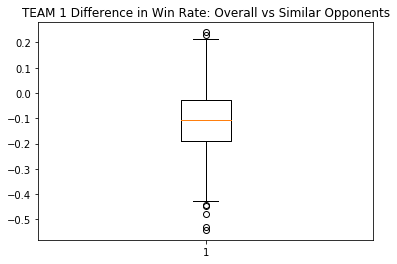

In [595]:
# dif in percentage points between similar team win rate & overall win rate
# (> 0 ) means team is more likely to win against similar opponents

import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('TEAM 1 Difference in Win Rate: Overall vs Similar Opponents')
ax1.boxplot(tourney_df['team1_win_rate_dif'])
plt.show()

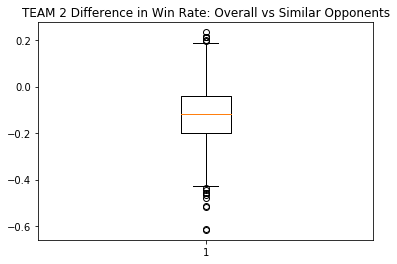

In [596]:
fig1, ax1 = plt.subplots()
ax1.set_title('TEAM 2 Difference in Win Rate: Overall vs Similar Opponents')
ax1.boxplot(tourney_df['team2_win_rate_dif'])
plt.show()

In [603]:
# check out 2019 tourney games for Duke
tourney_df.loc[(tourney_df.Season == 2019) & 
    ((tourney_df.team1_TeamName=='Duke') | (tourney_df.team2_TeamName =='Duke'))][['team1_TeamName',
                                                                                    'team2_TeamName',
                                                                                   'team1_WP',
                                                                                   'team2_WP',
                                                                                    'team1_pct_wins_similar',
                                                                                   'team2_pct_wins_similar',
                                                                                  'outcome',
                                                                                  'team1_Seed',
                                                                                  'team2_Seed']]

,team1_TeamName,team2_TeamName,team1_WP,team2_WP,team1_pct_wins_similar,team2_pct_wins_similar,outcome,team1_Seed,team2_Seed
1055,N Dakota St,Duke,0.516129,0.852941,0.153846,0.909091,L,16,1
1067,UCF,Duke,0.741935,0.852941,0.600000,0.833333,L,9,1
1072,Virginia Tech,Duke,0.750000,0.852941,0.500000,0.846154,L,4,1
1076,Duke,Michigan St,0.852941,0.823529,0.727273,0.454545,L,1,2


In [607]:
tourney_df.to_csv(our_data_dir + 'tourney_df_w_similar_opponent_scores.csv',index=False)